# Store_sales anaysis and Forecasting


https://www.kaggle.com/competitions/store-sales-time-series-forecasting

In [499]:
import time
import itertools
import calendar as cal
import numpy as np 
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import pacf, acf

In [500]:
trainPath = r"Store_sales\train.csv"
testPath = r"Store_sales\test.csv"
holidaysPath = r"Store_sales\holidays_events.csv"
oilPath = r"Store_sales\oil.csv"
storesPath = r"Store_sales\stores.csv"
transactionsPath = r"Store_sales\transactions.csv"

train = pd.read_csv(trainPath,parse_dates=['date'])
test = pd.read_csv(testPath,parse_dates=['date'])
holidays_events = pd.read_csv(holidaysPath,parse_dates=['date'])
oil = pd.read_csv(oilPath,parse_dates=['date'])
stores = pd.read_csv(storesPath)
transactions = pd.read_csv(transactionsPath,parse_dates=['date'])

print(f"Training Data: from {train.date.min()} to {train.date.max()} - {train.date.max() - train.date.min()}")
print(f"Testing Data: from {test.date.min()} to {test.date.max()} - {test.date.max() - test.date.min()}")

Training Data: from 2013-01-01 00:00:00 to 2017-08-15 00:00:00 - 1687 days 00:00:00
Testing Data: from 2017-08-16 00:00:00 to 2017-08-31 00:00:00 - 15 days 00:00:00


In [501]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [378]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB
None


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [379]:
# calendar dataset covering train + test dates
calendar = pd.DataFrame(index=pd.date_range(train.date.min(), test.date.max()))
# days of week
calendar['weekday'] = calendar.index.dayofweek 

# Data analysis

In [502]:
train_ext = train.merge(stores, on='store_nbr', how='left')
train_ext = train_ext.merge(transactions, on=['date', 'store_nbr'], how='left')
train_ext = train_ext.rename(columns={"type": "store_type"})
train_ext = train_ext.merge(oil, on='date', how='left')
train_ext['date'] = train_ext['date'].astype('datetime64[ns]')
train_ext['year'] = train_ext['date'].dt.year
train_ext['month'] = train_ext['date'].dt.month
train_ext['week'] = train_ext['date'].dt.isocalendar().week
train_ext['quarter'] = train_ext['date'].dt.quarter
train_ext['weekday'] = train_ext['date'].dt.dayofweek
train_ext['day_name'] = train_ext['date'].dt.day_name()



test = test.merge(stores, on='store_nbr', how='left')
test = test.merge(transactions, on=['date', 'store_nbr'], how='left')
test = test.rename(columns={"type": "store_type"})
test = test.merge(oil, on='date', how='left')
test['date'] = test['date'].astype('datetime64[ns]')
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['week'] = test['date'].dt.isocalendar().week
test['quarter'] = test['date'].dt.quarter
test['weekday'] = test['date'].dt.dayofweek
test['day_name'] = test['date'].dt.day_name()

## Stores

In [381]:
def print_summary(data:dict, title):
    fig=go.Figure()
    fig.add_trace(go.Scatter(
        x=np.arange(start=0, stop=len(data)),
        y=np.full(len(data), 1.6),
        mode="text", 
        text=[f"<span style='font-size:33px'><b>{data[x]}</b></span>" for x in data],
        textposition="bottom center",
        hoverinfo='skip'
    ))
    fig.add_trace(go.Scatter(
        x=np.arange(start=0, stop=len(data)),
        y=np.full(len(data), 1.1),
        mode="text", 
        text=[x for x in data],
        textposition="bottom center",
        hoverinfo='skip'
    ))
    fig.add_hline(y=2.2, line_width=5, line_color='gray')
    fig.add_hline(y=0.3, line_width=3, line_color='gray')
    fig.update_yaxes(visible=False)
    fig.update_xaxes(visible=False)
    fig.update_layout(
        showlegend=False, height=300, width=1200,
        title=title, title_x=0.5, title_y=0.9,
        yaxis_range=[-0.2,2.2],
        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
        font=dict(size=23, color='#323232'),
        title_font=dict(size=35, color='#222'),
        margin=dict(t=90,l=70,b=0,r=70)
    )
    fig.show(config={'staticPlot': False})

In [382]:
start_date = train_ext.date.min()
end_date = train_ext.date.max()
nb_months = round((end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + (end_date.day / 30.5), 1)

summary = {
    "Stores": stores.shape[0],
    "Store types": train_ext.store_type.nunique(),
    "Store clusters": train_ext.cluster.nunique(),
    "Product families": train_ext.family.nunique(),
    "States": train_ext.state.nunique(),
    "Months": nb_months
}
print_summary(summary, "Stores Summary")

## Sales

In [383]:
df_sales = train.groupby('date').agg({"sales" : "sum"}).reset_index()
df_sales['sales_ma'] = df_sales['sales'].rolling(7).mean()
df_trans = transactions.groupby('date').agg({"transactions" : "sum"}).reset_index()
df_trans['transactions_ma'] = df_trans['transactions'].rolling(7).mean()

In [384]:
fig = make_subplots(rows=3, cols=1,
                    subplot_titles=["Sales", "Transactions", "Sales / Transactions"],
                    vertical_spacing=.1)
fig.add_scatter(x=df_sales['date'], y=df_sales['sales'],
                mode='lines', marker=dict(color='#428bca'),
                name='Sales', row=1, col=1)
fig.add_scatter(x=df_sales['date'], y=df_sales['sales_ma'],
                mode='lines', marker=dict(color='#d9534f'),
                name='7d moving avearge', row=1, col=1)
fig.add_scatter(x=df_trans['date'], y=df_trans['transactions'],
                mode='lines', marker=dict(color='#428bca'),
                name='Transactions', row=2, col=1)
fig.add_scatter(x=df_trans['date'], y=df_trans['transactions_ma'],
                mode='lines', marker=dict(color='#d9534f'),
                name='7d moving avearge', row=2, col=1)
fig.add_scatter(x=df_sales['sales'], y=df_trans['transactions'],
                mode='markers', marker=dict(color='#428bca', size=2),
                name='Sales/Transactions', row=3, col=1)
# style
fig.update_xaxes(title='Sales', row=3, col=1)
fig.update_yaxes(title='Transactions', row=3, col=1)
fig.update_layout(height=750, width=1200, showlegend=False, **{'template': "plotly_white"})
fig.show()

In [385]:
df_st_sa = train_ext.groupby('store_type').agg({"sales" : "mean"}).sort_values(by='sales', ascending=False).reset_index()
df_fa_sa = train_ext.groupby('family').agg({"sales" : "mean"}).sort_values(by='sales', ascending=False)[:10].reset_index()
df_fa_sa['percent'] = round((df_fa_sa['sales'] / df_fa_sa['sales'].sum()) * 100, 1)
df_fa_sa['percent'] = df_fa_sa['percent'].astype(str) + "%"
df_fa_sa['color'] = '#c6ccd8'
df_fa_sa['color'].at[df_fa_sa.sales.idxmax()] = '#496595' 
df_cl_sa = train_ext.groupby('cluster').agg({"sales" : "mean"}).reset_index()
df_cl_sa['percent'] = round((df_cl_sa['sales'] / df_cl_sa['sales'].sum()) * 100, 1)
df_cl_sa['percent'] = df_cl_sa['percent'].astype(str) + "%"
df_cl_sa['color'] = '#c6ccd8'
df_cl_sa['color'].at[df_cl_sa.sales.idxmax()] = '#496595'


fig = make_subplots(rows=2, cols=2,
                    column_widths=[0.5, 0.5], vertical_spacing=0, horizontal_spacing=0.02,
                    specs=[[{"type": "bar"}, {"type": "pie"}], [{"colspan": 2}, None]],
                    subplot_titles=("Top 10 Highest Product Sales", "Sales per Store Types", "Sales per Clusters"))
fig.add_trace(go.Bar(x=df_fa_sa['sales'], y=df_fa_sa['family'], text=df_fa_sa['percent'],
                     marker=dict(color=df_fa_sa['color']), name='Family', orientation='h'),
              row=1, col=1)
fig.add_trace(go.Pie(values=df_st_sa['sales'], labels=df_st_sa['store_type'],
                     name='Store type', hole=0.7,
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']),
                     hoverinfo='label+percent+value', textinfo='label'),
              row=1, col=2)
fig.add_trace(go.Bar(x=df_cl_sa['cluster'], y=df_cl_sa['sales'], text=df_cl_sa['percent'],
                     marker=dict(color=df_cl_sa['color']), name='Cluster'), 
              row=2, col=1)


fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_cl_sa.cluster, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, width=1000, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  showlegend=False, **{'template': "plotly_white"})
fig.show()

In [386]:
df_m_sa = train_ext.groupby('month').agg({"sales" : "mean"}).reset_index()
df_m_sa['sales'] = round(df_m_sa['sales'], 2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: cal.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['sales'].astype(str)
df_m_sa['color'] = '#c6ccd8'
df_m_sa['color'].at[df_m_sa.sales.idxmax()] = '#496595'

df_dw_sa = train_ext.groupby('weekday').agg({"sales" : "mean"}).reset_index()
df_dw_sa.sales = round(df_dw_sa.sales, 2)
df_dw_sa['day_name'] = df_dw_sa['weekday'].apply(lambda x: cal.day_name[x])
df_dw_sa['text'] = df_dw_sa['day_name'] + ' - ' + df_m_sa['sales'].astype(str)
df_dw_sa['color'] = '#c6ccd8'
df_dw_sa['color'].at[df_dw_sa.sales.idxmax()] = '#496595'

df_w_sa = train_ext.groupby('week').agg({"sales" : "mean"}).reset_index()
df_q_sa = train_ext.groupby('quarter').agg({"sales" : "mean"}).reset_index()
df_w_sa['color'] = '#c6ccd8'

fig = make_subplots(rows=2, cols=3,
                    vertical_spacing=0.08,
                    row_heights=[0.7, 0.3],
                    specs=[[{"type": "bar"}, {"type": "pie"}, {"type": "bar"}], [{"colspan": 3}, None, None]],
                    subplot_titles=("Month wise Avg Sales Analysis",
                                    "Quarter wise Avg Sales Analysis",
                                    "Day wise Avg Sales Analysis",
                                    "Week wise Avg Sales Analysis"))
fig.add_trace(go.Bar(x=df_m_sa['sales'], y=df_m_sa['month'][::-1],
                     marker=dict(color=df_m_sa['color']),
                     text=df_m_sa['text'], textposition='auto',
                     name='Month', orientation='h'), row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['sales'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']),
                     hole=0.7, hoverinfo='label+percent+value', textinfo='label+percent'), row=1, col=2)
fig.add_trace(go.Bar(x=df_dw_sa['sales'], y=df_dw_sa['weekday'][::-1],
                     marker=dict(color=df_dw_sa['color']),
                     text=df_dw_sa['text'], textposition='auto',
                     name='Day', orientation='h'), row=1, col=3)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['sales'],
                         mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                         marker=dict(color='#496595'), name='Week'), row=2, col=1)

fig.update_yaxes(visible=False, row=1, col=1)
fig.update_yaxes(visible=False, row=1, col=3)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_layout(height=500, width=1000, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Sales Analysis Over Time",
                  showlegend=False, **{'template': "plotly_white"})
fig.show()

# Machine Learning

I will try all the models possible on the differents products to have the models adapted to the product. 
Moreover, I will try this model by taking data from differents date.

In [503]:
import warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed

In [504]:
train_ext

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,dcoilwtico,year,month,week,quarter,weekday,day_name
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,NaN,2013,1,1,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,NaN,2013,1,1,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,NaN,2013,1,1,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,NaN,2013,1,1,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,NaN,2013,1,1,1,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2155.0,47.57,2017,8,33,3,1,Tuesday
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2155.0,47.57,2017,8,33,3,1,Tuesday
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2155.0,47.57,2017,8,33,3,1,Tuesday
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2155.0,47.57,2017,8,33,3,1,Tuesday


In [505]:
len(train_ext["family"].unique())

33

In [506]:
#Encode the data

le = LabelEncoder()
    
train_ext["transactions"] = train_ext["transactions"].fillna(value=0)
train_ext["dcoilwtico"] = train_ext["dcoilwtico"].fillna(value=train_ext["dcoilwtico"].mean())
train_ext["city"] = le.fit_transform(train_ext["city"])
train_ext["state"] = le.fit_transform(train_ext["state"])
train_ext["store_type"] = le.fit_transform(train_ext["store_type"])
train_ext["day_name"] = le.fit_transform(train_ext["day_name"])
train_ext=train_ext.drop("date",axis=1)

test["transactions"] = test["transactions"].fillna(value=0)
test["dcoilwtico"] = test["dcoilwtico"].fillna(value=test["dcoilwtico"].mean())
test["city"] = le.fit_transform(test["city"])
test["state"] = le.fit_transform(test["state"])
test["store_type"] = le.fit_transform(test["store_type"])
test["day_name"] = le.fit_transform(test["day_name"])
test=test.drop("date",axis=1)

mapping = {train_ext["family"].unique()[i] : i+1 for i in range(33)}
train_ext["family"] = train_ext["family"].map(mapping)
test["family"] = test["family"].map(mapping)
train_ext



,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,dcoilwtico,year,month,week,quarter,weekday,day_name
0,0,1,1,0.000,0,18,12,3,13,0.0,67.925589,2013,1,1,1,1,5
1,1,1,2,0.000,0,18,12,3,13,0.0,67.925589,2013,1,1,1,1,5
2,2,1,3,0.000,0,18,12,3,13,0.0,67.925589,2013,1,1,1,1,5
3,3,1,4,0.000,0,18,12,3,13,0.0,67.925589,2013,1,1,1,1,5
4,4,1,5,0.000,0,18,12,3,13,0.0,67.925589,2013,1,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,9,29,438.133,0,18,12,1,6,2155.0,47.570000,2017,8,33,3,1,5
3000884,3000884,9,30,154.553,1,18,12,1,6,2155.0,47.570000,2017,8,33,3,1,5
3000885,3000885,9,31,2419.729,148,18,12,1,6,2155.0,47.570000,2017,8,33,3,1,5
3000886,3000886,9,32,121.000,8,18,12,1,6,2155.0,47.570000,2017,8,33,3,1,5


In [507]:
def best_model(data):
    #As input, there will be a sales dataset of the same category
    #It will return the best model from the data
    #It will train on 2 weeks like the test file

    test_data = data[(data['year']==2017) & (data['month']==8)]
    train_data = data[~((data['year']==2017) & (data['month']==8))]
    x_test = test_data.drop('sales',axis=1)
    y_test = test_data['sales']
    x_train = train_data.drop('sales',axis=1)
    y_train = train_data['sales']    

    
    #Créons nos modèles
    
    reg = regression(x_train,y_train,x_test)
    reg[reg<0]=0
    
    SGD = SGDreg(x_train,y_train,x_test)
    SGD[SGD<0]=0
    
    Rid = ridge(x_train,y_train,x_test,a=100)
    Rid[Rid<0]=0
    
    rdm = random_forest(x_train,y_train,x_test,n=8,d=2)
    rdm[rdm<0]=0 
    

    return([RMSLE(y_test,reg),RMSLE(y_test,SGD), RMSLE(y_test,Rid), RMSLE(y_test,rdm)])



def regression(x,y,x_test):
    mod = Pipeline([('scaler',StandardScaler()),('reg',LinearRegression(fit_intercept=True,positive=True))])
    mod.fit(x, y)
    return(pd.DataFrame(mod.predict(x_test)))
        
    
def RMSLE(real,pred):
    return(np.sqrt(mean_squared_log_error(real, pred)))

def random_forest(x,y,x_test,n=10,d=2):
    mod = Pipeline([('scaler',StandardScaler()),('forest',RandomForestRegressor(n_estimators=n,max_depth=d))])
    mod.fit(x, y)
    return(pd.DataFrame(mod.predict(x_test)))

def ridge(x,y,x_test,a=10,t=0.001):
    mod = Pipeline([('scaler',StandardScaler()),('forest',Ridge(alpha=a,tol=t))])
    mod.fit(x, y)
    return(pd.DataFrame(mod.predict(x_test))) 

def SGDreg(x,y,x_test,n=1000,t=0.001):
    mod = Pipeline([('scaler',StandardScaler()),('SGD',SGDRegressor(max_iter=n, tol=t))])
    mod.fit(x, y)
    return(pd.DataFrame(mod.predict(x_test)))


    
    
def best(data): 
        
    R=[]
    S=[]
    I=[]
    M=[]
    mois = list(np.arange(48,56))
    for i in mois:
        a = best_model(data[(data["month"]>=(i%12)) & (data["year"]>=(2013+(i//12)))])
        R.append(a[0])
        S.append(a[1])
        I.append(a[2])
        M.append(a[3])

    plt.plot(mois,R,label="Regression",c='r')
    plt.plot(mois,S,label="SGDreg",c='b')
    plt.plot(mois,I,label="Ridge",c='black')
    plt.plot(mois,M,label="random_forest",c='g')    
        
    return(R,S,I,M)    

        

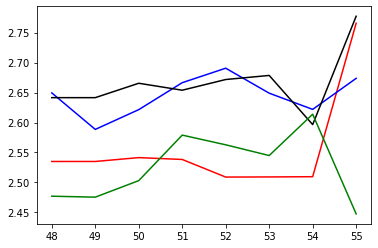

In [311]:
R,S,I,M=best(train_ext)

The error is minimal when the training is done on the year 2017. So we will stay with it. The models will be trained from January 2017. We also could adapt the dates according to the sales family.

In [508]:
train_df = train_ext[(train_ext["month"]>=(49%12)) & (train_ext["year"]>=(2013+(49//12)))]

We will now group sales according to product family. 

In [509]:
list = train_df['family'].unique()
list

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [510]:
df = train_df.groupby('family')

datatest = test.groupby('family')

pd.concat([df.get_group(i) for i in range(1,34)]).sort_values('id')

,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,dcoilwtico,year,month,week,quarter,weekday,day_name
2596374,2596374,1,1,0.000,0,18,12,3,13,0.0,67.925589,2017,1,52,1,6,3
2596375,2596375,1,2,0.000,0,18,12,3,13,0.0,67.925589,2017,1,52,1,6,3
2596376,2596376,1,3,0.000,0,18,12,3,13,0.0,67.925589,2017,1,52,1,6,3
2596377,2596377,1,4,0.000,0,18,12,3,13,0.0,67.925589,2017,1,52,1,6,3
2596378,2596378,1,5,0.000,0,18,12,3,13,0.0,67.925589,2017,1,52,1,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,9,29,438.133,0,18,12,1,6,2155.0,47.570000,2017,8,33,3,1,5
3000884,3000884,9,30,154.553,1,18,12,1,6,2155.0,47.570000,2017,8,33,3,1,5
3000885,3000885,9,31,2419.729,148,18,12,1,6,2155.0,47.570000,2017,8,33,3,1,5
3000886,3000886,9,32,121.000,8,18,12,1,6,2155.0,47.570000,2017,8,33,3,1,5


In [511]:
def Final_list(df):
    
    L=[]
    
    for i in range(1,34):
        a=best_model(df.get_group(i))
        L.append(a.index(min(a)))
    return(L)

In [512]:
def calcul(df,test):
    L=Final_list(df)
    R=[]
    ID=[]
    for i in range(1,34):
        a=df.get_group(i)
        x = a.drop('sales',axis=1)
        y = a['sales'] 
        if L[i-1]==0:
            mod = Pipeline([('scaler',StandardScaler()),('reg',LinearRegression(fit_intercept=True,positive=True))])
            mod.fit(x, y)
        if L[i-1]==1:
            mod = Pipeline([('scaler',StandardScaler()),('SGD',SGDRegressor(max_iter=1000, tol=0.001))])
            mod.fit(x, y)
        if L[i-1]==2:
            mod = Pipeline([('scaler',StandardScaler()),('forest',Ridge(alpha=100,tol=0.001))])
            mod.fit(x, y)
        else:
            mod = Pipeline([('scaler',StandardScaler()),('forest',RandomForestRegressor(n_estimators=8,max_depth=2))])
            mod.fit(x, y)
        R.append(mod.predict(test.get_group(i)))
        ID.append(test.get_group(i)["id"])
    return R , ID
    

In [513]:
R, ID = calcul(df,datatest)

In [514]:
pd.concat(pd.DataFrame(data = {"id" : ID[i-1], "sales" : R[i-1]}) for i in range(1,34)).sort_values('id').to_csv("Second.csv",sep=',',index=False,decimal='.')

Here is the end of this competition for me. My score is 1.50946. 
You can find my github here : https://github.com/yan-maz